In [1]:
import xarray as xr 
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import colorsys
#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects

#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'
colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']
from scipy.ndimage import gaussian_filter

from metpy.interpolate import cross_section
import metpy.calc as mpcalc
from scipy import stats
from metpy.calc import lat_lon_grid_deltas, first_derivative

from metpy.units import units

## Plot Q forcing mean associated with Low and High anomalies, Centered on highest Precip


### 1 Run H_anom to get all levels H anomalies at TP days for each region
### 2 Run Geowind to calculate the geostrophic wind due to high and low anomalies at TP days for each region
### 3 Run highH_Omega_Inversion and lowH_Omega_Inversion_Analysis11 to get Omega from Q forcing associated with high and low anomalies in TP days for each region
### 4 Plot results below


## Plot Q forcing mean associated with Low and High anomalies with windlowH_Q, Centered on highest Precip

In [2]:
r = 3
lev = 700
slice_start = np.array([-36, 36, 108, 180 , -108])
slice_end = np.array([36, 108, 180, 252, -36])

lowH_Q = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Contribution_H_L/lowH_Q_region'+str(r)).sel(lev = lev).omega_Q_full.load()
highH_Q = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Contribution_H_L/highH_Q_region'+str(r)).sel(lev = lev).omega_Q_full.load()
if r == 0 or r ==4:
    lowH_Q = lowH_Q.isel(lon = slice(0,230))
    highH_Q = highH_Q.isel(lon = slice(0,230))
region_lons = lowH_Q.sel(lon = slice(slice_start[r], slice_end[r])).lon.values


lowH_wind = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Contribution_H_L/lowH_geostrophic_wind_region'+str(r)+'.nc').sel(lev = lev, lat = slice(-85, -40))
highH_wind = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Contribution_H_L/highH_geostrophic_wind_region'+str(r)+'.nc').sel(lev = lev, lat = slice(-85, -40))
basins_slice_start = [-72,  0,  72,  144, -144]
basins_slice_end = [ 71.5, 143.5, 216, 288,  -.5]
basins = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-85,-40)).load()
if r==2 or r == 3:
    lowH_wind = lowH_wind.assign_coords({'lon' :('lon_original',np.concatenate([np.arange(180,360,.625),np.arange(0,180,.625)]))})
    lowH_wind = lowH_wind.swap_dims({'lon_original':'lon'})
    lowH_wind = lowH_wind.sortby('lon')
    highH_wind = highH_wind.assign_coords({'lon' :('lon_original',np.concatenate([np.arange(180,360,.625),np.arange(0,180,.625)]))})
    highH_wind = highH_wind.swap_dims({'lon_original':'lon'})
    highH_wind = highH_wind.sortby('lon')

lowH_wind = lowH_wind.sel(lon = slice(lowH_Q.lon[0].values, lowH_Q.lon[-1].values)).vgeo.load()
highH_wind = highH_wind.sel(lon = slice(lowH_Q.lon[0].values, lowH_Q.lon[-1].values)).vgeo.load()
region_lons_wind = lowH_wind.sel(lon = slice(slice_start[r], slice_end[r])).lon.values

basins = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-85,-40)).load()
if r==2 or r == 3:
    basins = basins.assign_coords({'lon' :('lon_original',np.concatenate([np.arange(180,360,.625),np.arange(0,180,.625)]))})
    basins = basins.swap_dims({'lon_original':'lon'})
    basins = basins.sortby('lon')
    
    
basins = basins.Zwallybasins == 0
basins = basins.sel(lon  = slice(basins_slice_start[r], basins_slice_end[r]))


#mask out continent
lowH_Q = lowH_Q*basins.values
highH_Q = highH_Q*basins.values
lowH_wind = lowH_wind*basins.values
highH_wind = highH_wind*basins.values

precip_weights = np.array(pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Precip/TP_precip_weights_region'+str(r)+'.csv', index_col = 0))
len_shifted_weights = 460
num_times = int(np.shape(precip_weights)[0])

lowH_shifted_Q = np.empty((num_times, len(lowH_Q.lat), len_shifted_weights))
highH_shifted_Q = np.empty((num_times, len(lowH_Q.lat), len_shifted_weights))
lowH_shifted_wind = np.zeros((num_times, len(lowH_wind.lat), len_shifted_weights))
highH_shifted_wind = np.zeros((num_times, len(lowH_wind.lat), len_shifted_weights))

for t in range(num_times):
    max_id = int(np.where(precip_weights[t] == precip_weights[t].max())[0])
    max_id_data = int(np.where(highH_Q.lon.values==region_lons[max_id])[0])
    lowH_shifted_Q[t][:,(230-max_id_data):(460-max_id_data)] = lowH_Q[t].values
    highH_shifted_Q[t][:,(230-max_id_data):(460-max_id_data)] = highH_Q[t].values
    
    max_id_data = int(np.where(highH_wind.lon.values==region_lons_wind[max_id])[0])
    lowH_shifted_wind[t][:,(230-max_id_data):(460-max_id_data)] = lowH_wind[t].values
    highH_shifted_wind[t][:,(230-max_id_data):(460-max_id_data)] = highH_wind[t].values



/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/projects/reba1583/software/anaconda/envs/research/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


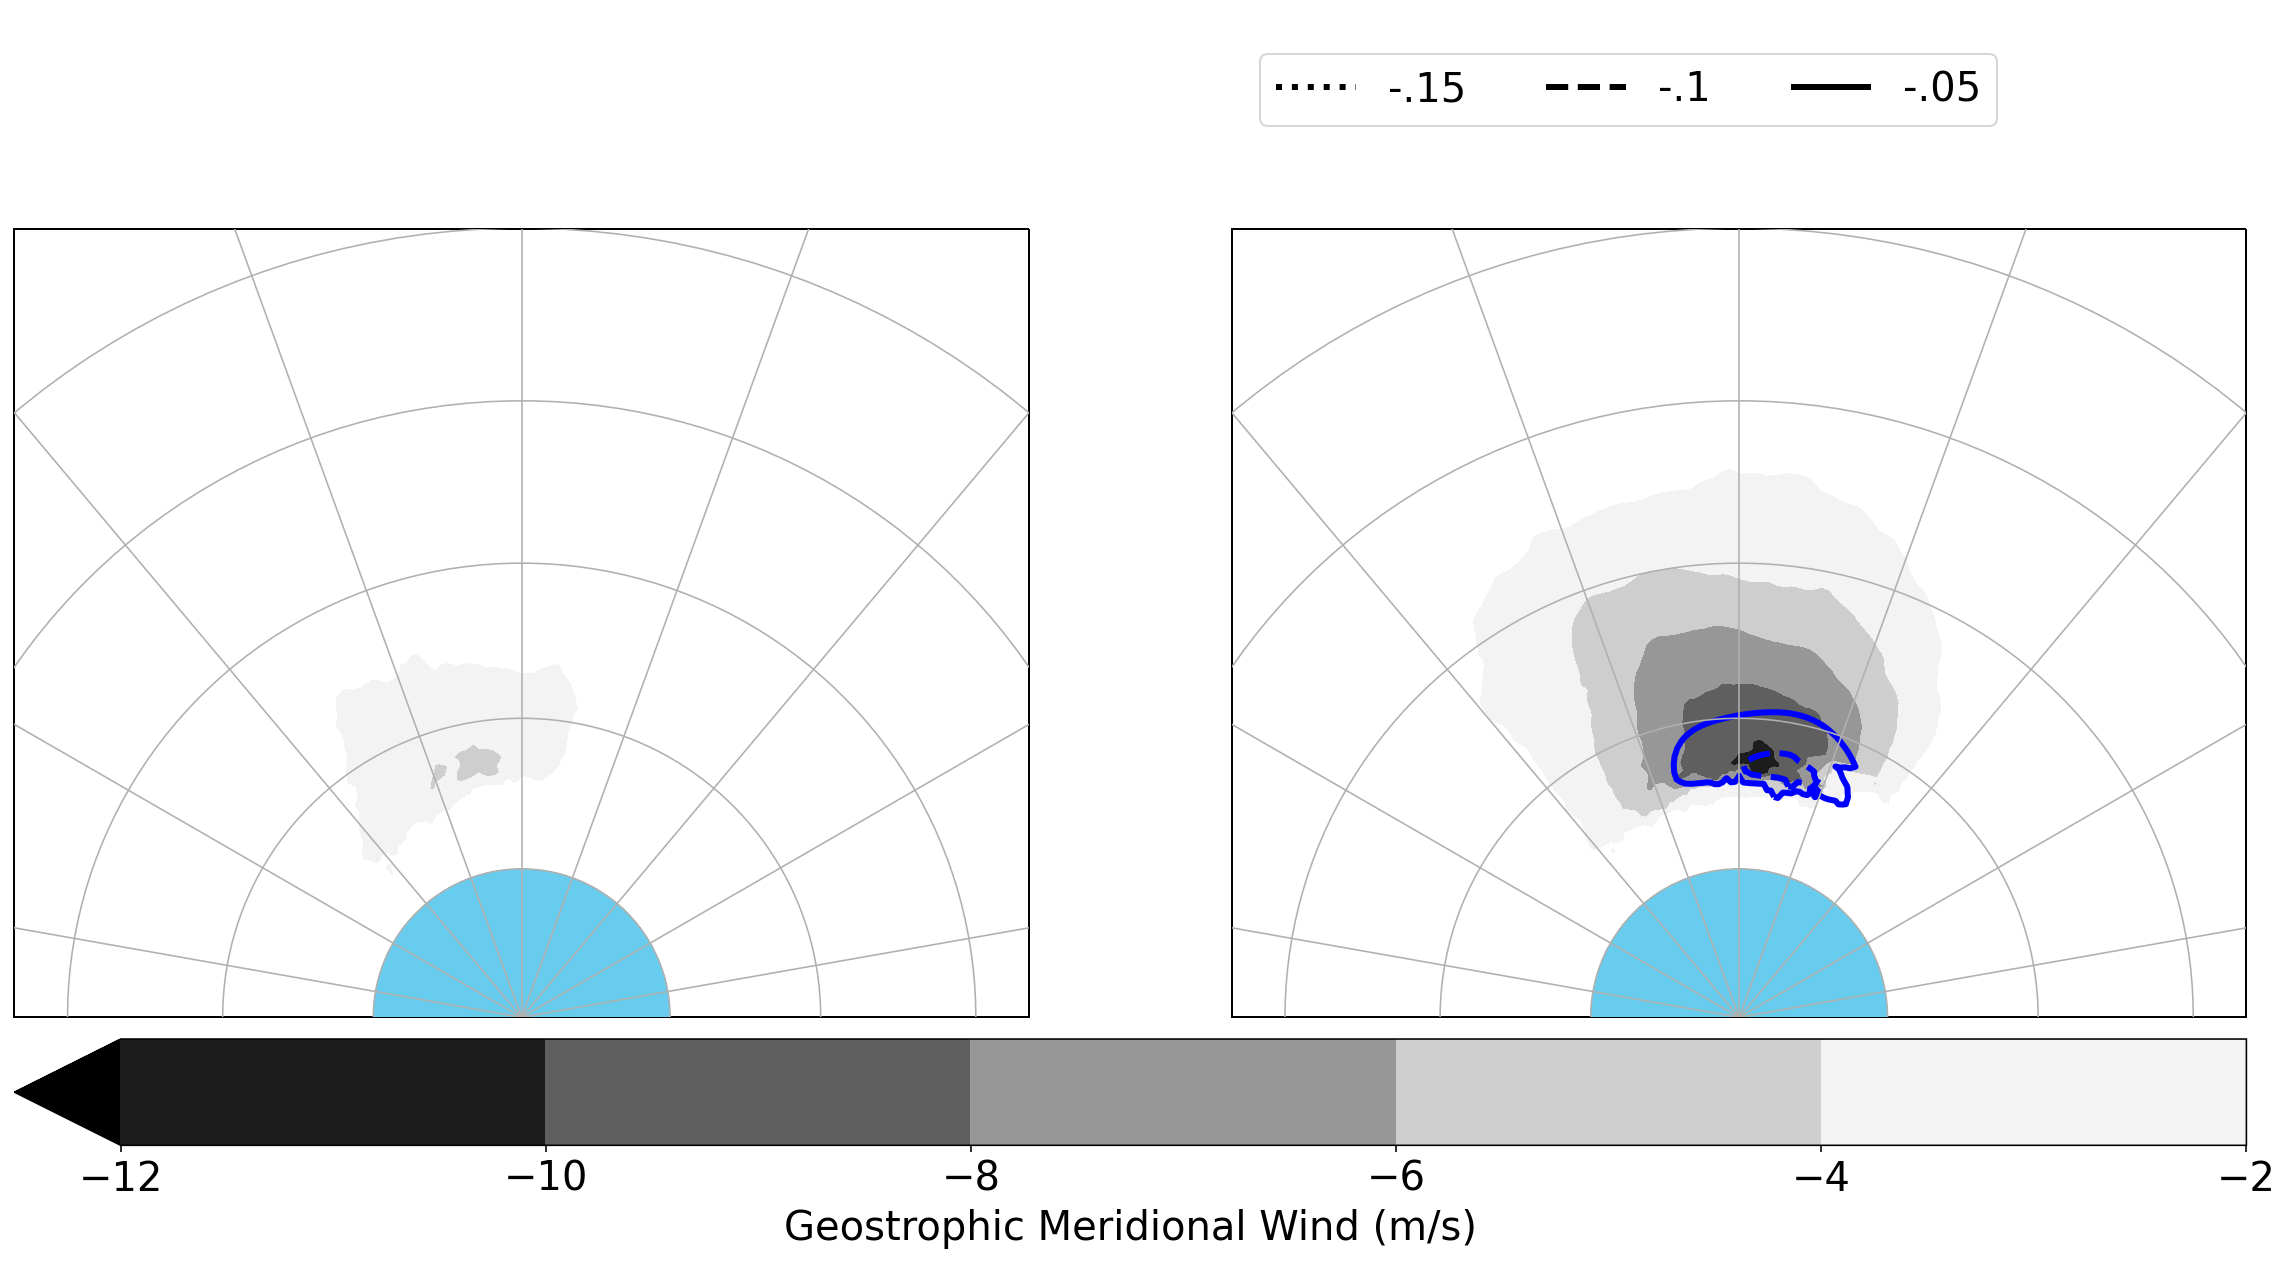

In [3]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10), subplot_kw={'projection': ccrs.SouthPolarStereo()})
slice_data = basins.sel(lon  = slice(slice_start[r], slice_end[r]))
ax = axes.ravel()
for a in ax:
    a.set_extent([-40, 40, -90, -40], ccrs.PlateCarree())
    grid=a.gridlines(zorder = 20)
    grid.n_steps=100
    a.contourf(np.arange(-115,115,1), np.arange(-90, -79.5, .5), np.ones((21, 230)), levels = np.arange(-.5,1.5,.75),cmap = ListedColormap([ 'None', colors[r]]), 
           transform=ccrs.PlateCarree(), zorder = 11)

levels_contour_wind = np.arange(-12,0,2)
levels_contour_omega = np.arange(-.15,0,.05)

    
a = axes[0]
cf = a.contourf(np.arange(-230,230,1), basins.lat, np.mean(lowH_shifted_wind, 0), levels = levels_contour_wind, extend = 'min',cmap = 'Greys_r', transform=ccrs.PlateCarree())
cf_low = a.contour(np.arange(-230,230,1), basins.lat.values, np.nanmean(lowH_shifted_Q, 0), linewidths = 3,levels = levels_contour_omega,linestyles= [ 'dotted','dashed',  'solid'], colors = 'red',transform=ccrs.PlateCarree())




a = axes[1]
cf = a.contourf(np.arange(-230,230,1), basins.lat, np.mean(highH_shifted_wind, 0), levels = levels_contour_wind, extend = 'min', cmap = 'Greys_r', transform=ccrs.PlateCarree())
cf_high = a.contour(np.arange(-230,230,1), basins.lat.values, np.nanmean(highH_shifted_Q, 0), linewidths = 3,levels = levels_contour_omega,linestyles= [ 'dotted','dashed',  'solid'], colors = 'blue',transform=ccrs.PlateCarree())



cbar = fig.colorbar(cf, ax = ax, orientation = 'horizontal', pad = .02)
cbar.ax.set_title('Geostrophic Meridional Wind (m/s)', fontsize=20, y = -1)
cbar.ax.tick_params(labelsize=20)

# labels2 = ['Low Pressure Anomaly Q_Forced Omega', 'High Pressure Anomaly Q_Forced Omega']
# cf_low.collections[-1].set_label(labels2[0])
# cf_high.collections[-1].set_label(labels2[1])
# leg2=fig.legend(loc=(.02,.88), ncol=2, fontsize=20)
# for line in leg2.get_lines():
#     line.set_linewidth(3)

labels = [ '-.15', '-.1', '-.05']
for l in range(len(labels)):
    cf_high.collections[l].set_label(labels[l])
leg=fig.legend(loc=(.55,.9), ncol=4, fontsize=20)
for line in leg.get_lines():
    line.set_linewidth(3)
    line.set_color('black')


# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/low_vs_high_lift_and_wind_region'+str(r)+'.png', dpi = 300, transparent = True, bbox_inches = 'tight')
